In [2]:
import sys
import numpy as np

from astroquery.simbad import Simbad

from astropy.io import fits, ascii
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.timeseries import BoxLeastSquares, LombScargle
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table, Column
import astropy.units as u

from scipy.ndimage import shift
from scipy.stats import chisquare
from scipy.signal import medfilt, find_peaks
from scipy.odr import Model, RealData, ODR

from photutils import DAOStarFinder, CircularAperture, aperture_photometry
from ccdproc import CCDData, Combiner, subtract_overscan, trim_image
from astroquery.mast import Catalogs
from reproject import reproject_interp

from glob import glob

import matplotlib

%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import NullLocator
from matplotlib.ticker import ScalarFormatter

## P-A relations in literature

- Mine: $\log t =  (8.73 \pm 0.05) - (0.82 \pm 0.07) \log P$
- Bono et al 2005 (choosing their metallicity = 0.004, and the fundamental): $\log t =  (8.49 \pm 0.09) - (.79 \pm 0.01) \log P$
- Magnier et al 1997: $\log t =  8.4 - 0.6 \log P$
- Efremov & Elmegreen 1998: $\log t =  8.492 - 0.677 \log P$
- Joshi & Joshi 2014: $\log t =  (8.6 \pm 0.07) - (0.77 \pm 0.08) \log P$
- Anderson et al 2016: $\log t =  8.628 - 0.665 \log P$

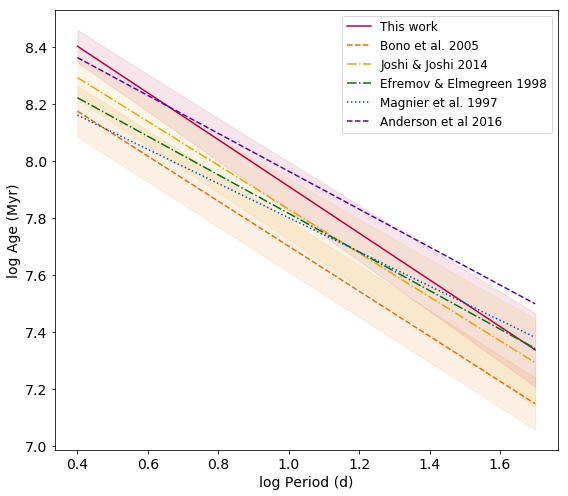

In [3]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

logP = np.linspace(0.4,1.7,14)

# This work
logt = 8.73 - 0.82*logP
logt_err = np.sqrt(0.05**2+(0.07*logP)**2)
ax1.plot(logP, logt, color='#b90043', label="This work")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#b90043', alpha=0.1)

# Bono et al 
logt = 8.49 - .79*logP
logt_err = np.sqrt(0.09**2+(0.01*logP)**2)
ax1.plot(logP, logt, linestyle='--', color='#e57001', label="Bono et al. 2005")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#e57001', alpha=0.1)

# Joshi & Joshi
logt = 8.6 - .77*logP
logt_err = np.sqrt(0.07**2+(0.08*logP)**2)
ax1.plot(logP, logt, linestyle='-.', color='#eca500', label="Joshi & Joshi 2014")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#eca500', alpha=0.1)

# Efremov & Elmegreen
logt = 8.492 - .677*logP
ax1.plot(logP, logt, linestyle='-.', color='#007215', label="Efremov & Elmegreen 1998")

# Magnier et al
logt = 8.4 - .6*logP
ax1.plot(logP, logt, linestyle=':', color='#0051c6', label="Magnier et al. 1997")

# Anderson et al
logt = 8.628 - .665*logP
ax1.plot(logP, logt, linestyle='--', color='#5f019c', label="Anderson et al 2016")


ax1.legend(fontsize=12)

ax1.set_xlabel("log Period (d)", size=14)
ax1.set_ylabel("log Age (Myr)", size=14)

fig.tight_layout()

plt.savefig("../doc/plots/period_age_comparison.pdf")
        
plt.show()  
        

## Recalculating with new values

In [4]:
pd_age_table = Table(names=["cluster","periods","age","e_age"],
                     data=[["NGC 1818","NGC 1850","NGC 2031","NGC 2136","NGC 2157","NGC 1866"],
                           [[39.999],
                            [18.6639, 8.55965, 7.92288],
                            [2.97151, 3.19436, 3.04226, 3.27879, 3.03111, 2.96081, 2.82426, 2.86926, 2.79717],
                            [4.41422, 9.1301, 4.46552],
                            [7.71987, 5.1472],
                            [3.205, 3.144, 2.642, 2.957, 3.443, 3.101, 3.037, 3.065, 3.044, 3.291, 3.065, 3.182, 
                             2.893, 3.058, 3.228, 2.728, 3.452, 3.316, 3.525, 3.086, 2.944]
                           ],
                           [30,80,230,125,100,141]*u.Myr,
                           [15,17,30,50,30,20]*u.Myr])

In [5]:
mean_pds = [round(np.mean(x),3) for x in pd_age_table['periods']]

errs = [0]*len(pd_age_table['periods'])
for i,pds in enumerate(pd_age_table['periods']):
    variance = sum([(x - mean_pds[i])**2 for x in pds])/(len(pds))
    errs[i] = round(np.sqrt(variance/len(pds)), 2)

In [6]:
pd_age_table.add_column(Column(name="ave_pd",data=mean_pds*u.day))
pd_age_table.add_column(Column(name="e_ave_pd",data=errs*u.day))
pd_age_table["e_ave_pd"][0] = 0.000001

In [7]:
pd_age_table

cluster,periods,age,e_age,ave_pd,e_ave_pd
,,Myr,Myr,d,d
str8,object,float64,float64,float64,float64
NGC 1818,[39.999],30.0,15.0,39.999,1e-06
NGC 1850,"[18.6639, 8.55965, 7.92288]",80.0,17.0,11.715,2.84
NGC 2031,"[2.97151, 3.19436, 3.04226, 3.27879, 3.03111, 2.96081, 2.82426, 2.86926, 2.79717]",230.0,30.0,2.997,0.05
NGC 2136,"[4.41422, 9.1301, 4.46552]",125.0,50.0,6.003,1.28
NGC 2157,"[7.71987, 5.1472]",100.0,30.0,6.434,0.91
NGC 1866,"[3.205, 3.144, 2.642, 2.957, 3.443, 3.101, 3.037, 3.065, 3.044, 3.291, 3.065, 3.182, 2.893, 3.058, 3.228, 2.728, 3.452, 3.316, 3.525, 3.086, 2.944]",141.0,20.0,3.115,0.05


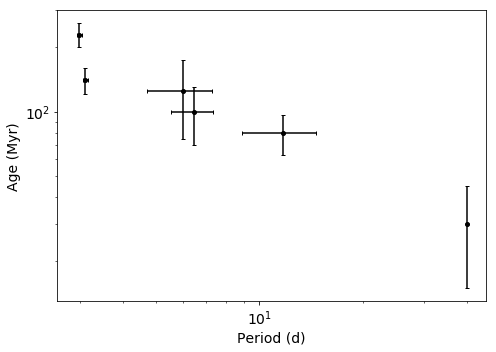

In [8]:
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax1.errorbar(pd_age_table["ave_pd"], pd_age_table["age"],
             xerr=pd_age_table["e_ave_pd"], yerr=pd_age_table["e_age"],
             capsize=2, linestyle='None',marker='o',color='black', markersize=4)  

ax1.set_xlabel("Period (d)", size=14)
ax1.set_ylabel("Age (Myr)", size=14)

ax1.set_xscale("log")
ax1.set_yscale("log")

fig.tight_layout()
        
plt.show()  

In [9]:
# The function we are fitting
def age_func(params, pd):
    a, b = params
    return 10**(a + b*np.log10(pd))*10**-6 # Want our result in Myr

# Create a model for fitting.
age_model = Model(age_func)

# Create a RealData object using our initiated data from above.
data = RealData(pd_age_table["ave_pd"], pd_age_table["age"], 
                sx=pd_age_table["e_ave_pd"], sy=pd_age_table["e_age"])

# Set up ODR with the model and data.
odr = ODR(data, age_model, beta0=[8.4, -1.07])

# Run the regression.
out = odr.run()

# Use the in-built pprint method to give us results.
out.pprint()

Beta: [ 8.54383185 -0.640442  ]
Beta Std Error: [0.11460277 0.17159825]
Beta Covariance: [[ 0.00906018 -0.01249614]
 [-0.01249614  0.02031292]]
Residual Variance: 1.449617356616098
Inverse Condition #: 0.1821371702599057
Reason(s) for Halting:
  Sum of squares convergence


#### Best fit P-A relation:

$\log t =  (8.54 \pm 0.11) - (0.64 \pm 0.17) \log P$

#### Plotting the results

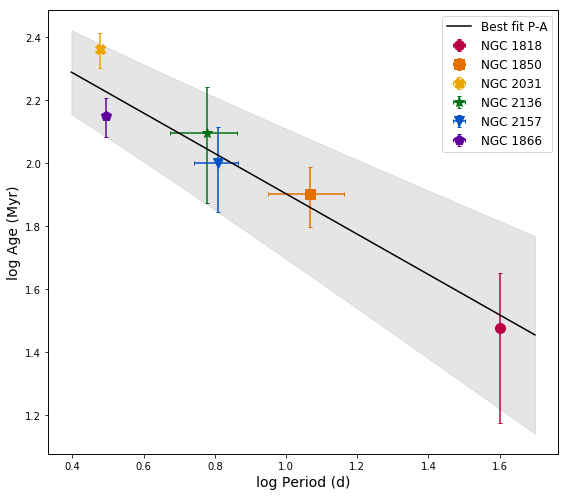

In [10]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

colors = ['#b90043','#e57001', '#eca500', '#007215', '#0051c6', '#5f019c']
markers = ['o','s','X','*','v','p']
i = 0
for cluster in pd_age_table:
    ax1.errorbar(cluster["ave_pd"], cluster["age"], xerr=cluster["e_ave_pd"], yerr=cluster["e_age"],
                 capsize=2, linestyle='None', markersize=10, label=cluster["cluster"],
                 color=colors[i], marker=markers[i],) 
    i+=1
    
x_fit = np.linspace(pd_age_table["ave_pd"].min()-0.5, pd_age_table["ave_pd"].max()+10, 1000)
y_fit = age_func(out.beta, x_fit)
ax1.plot(x_fit, y_fit, color='black', label="Best fit P-A")


y_err = np.sqrt(out.sd_beta[0]**2+(out.sd_beta[1]*np.log10(x_fit))**2)
y_min = 10**(np.log10(y_fit)+y_err)
y_max = 10**(np.log10(y_fit)-y_err)
plt.fill_between(x_fit, y_min, y_max, color='gray', alpha=0.2)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.axis('off')

ax1.legend(fontsize=12)

ax2 = ax1.twinx()
ax2.set_ylim(np.log10(ax1.get_ylim()))
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylabel("log Age (Myr)", size=14)

ax3 = ax1.twiny()
ax3.set_xlim(np.log10(ax1.get_xlim()))
ax3.xaxis.tick_bottom()
ax3.xaxis.set_label_position("bottom")
ax3.set_xlabel("log Period (d)", size=14)

fig.tight_layout()

plt.savefig("../doc/plots/period_age_relation_new.pdf")
        
plt.show()  
        

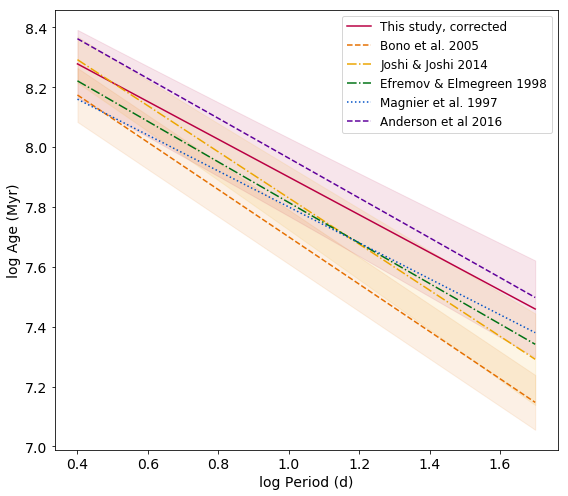

In [11]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=14)

logP = np.linspace(0.4,1.7,14)

# This work corrected
logt = 8.53 - 0.63*logP
logt_err = np.sqrt(0.11**2+(0.07*logP)**2)
ax1.plot(logP, logt, color='#b90043', label="This study, corrected")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#b90043', alpha=0.1)

# Bono et al 
logt = 8.49 - .79*logP
logt_err = np.sqrt(0.09**2+(0.01*logP)**2)
ax1.plot(logP, logt, linestyle='--', color='#e57001', label="Bono et al. 2005")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#e57001', alpha=0.1)

# Joshi & Joshi
logt = 8.6 - .77*logP
logt_err = np.sqrt(0.07**2+(0.08*logP)**2)
ax1.plot(logP, logt, linestyle='-.', color='#eca500', label="Joshi & Joshi 2014")
plt.fill_between(logP, logt+logt_err, logt-logt_err, color='#eca500', alpha=0.1)

# Efremov & Elmegreen
logt = 8.492 - .677*logP
ax1.plot(logP, logt, linestyle='-.', color='#007215', label="Efremov & Elmegreen 1998")

# Magnier et al
logt = 8.4 - .6*logP
ax1.plot(logP, logt, linestyle=':', color='#0051c6', label="Magnier et al. 1997")

# Anderson et al
logt = 8.628 - .665*logP
ax1.plot(logP, logt, linestyle='--', color='#5f019c', label="Anderson et al 2016")

ax1.legend(fontsize=12)

ax1.set_xlabel("log Period (d)", size=14)
ax1.set_ylabel("log Age (Myr)", size=14)

fig.tight_layout()

plt.savefig("../doc/plots/period_age_comparison_new.pdf")
        
plt.show()  
        